# 2. Simulation

Very important that the cell are run in their original order because there are some different results that have the same name 

In [431]:
# Import the libraries
import numpy as np 

import scipy as sci
from scipy.integrate import solve_ivp 

import time
import matplotlib.pyplot as plt 
from matplotlib import animation

from scipy.interpolate import interp1d

We firstly set the initial conditions

In [432]:
# ===========================
# Scenario A: Equal masses
# Rotating equilateral triangle
# ===========================

# Positions (equilateral triangle of side length ~1)
init_pos_1A = np.array([ 1.0, 0.0])
init_pos_2A = np.array([-0.5,  np.sqrt(3)/2])
init_pos_3A = np.array([-0.5, -np.sqrt(3)/2])

# Masses
m1A = m2A = m3A = 1.0
# Correct angular velocity for Lagrange equilateral solution
G = 1.0
a = np.sqrt(3.0)
omega = np.sqrt(3*G*m1A / a**3)

# Velocities for rigid rotation: v = omega * (-y, x)
init_vel_1A = omega * np.array([0.0,         1.0])             # (0, ω)
init_vel_2A = omega * np.array([-np.sqrt(3)/2, -0.5])          # (-√3/2 ω, -0.5 ω)
init_vel_3A = omega * np.array([ np.sqrt(3)/2, -0.5])   

In [433]:
init_cond_1 = np.array([
    init_pos_1A, init_pos_2A, init_pos_3A,
    init_vel_1A, init_vel_2A, init_vel_3A 
]).ravel()
#ravel to make it one dimensional to satisfy solve_ivp conditions
#init_cond needs to be an array as s variable in def system_odes also needs to be an array

In [434]:
# ===========================
# Scenario B: Unequal masses
# Same equilateral triangle geometry
# ===========================

# Positions (same as scenario A)
init_pos_1B = np.array([ 1.0, 0.0])
init_pos_2B = np.array([-0.5,  np.sqrt(3)/2])
init_pos_3B = np.array([-0.5, -np.sqrt(3)/2])

# Masses (unequal)
m1B, m2B, m3B = 1.0, 2.0, 3.0

# Start from the same rotational velocities as Scenario A
omega = 0.8
v1 = np.array([0.0,         omega])
v2 = np.array([0.7*omega,  -0.35*omega])
v3 = np.array([-0.7*omega, -0.35*omega])

# Adjust velocities so that total momentum = 0 (no drift)
M = m1B + m2B + m3B
v_com = (m1B*v1 + m2B*v2 + m3B*v3) / M

init_vel_1B = v1 - v_com
init_vel_2B = v2 - v_com
init_vel_3B = v3 - v_com


In [435]:
init_cond_2 = np.array([
    init_pos_1B, init_pos_2B, init_pos_3B,
    init_vel_1B, init_vel_2B, init_vel_3B 
]).ravel()
#ravel to make it one dimensional to satisfy solve_ivp conditions
#init_cond needs to be an array as s variable in def system_odes also needs to be an array

In [436]:
# ===========================
# Scenario C: One massive + two small
# "Scattering / non-orbiting" example
# ===========================

# Masses
m1C = 100.0   # big mass
m2C = 1.0     # small body 1
m3C = 1.0     # small body 2

G = 1.0

# Positions
init_pos_1C = np.array([0.0, 0.0])    # big mass near origin
init_pos_2C = np.array([5.0, 0.0])    # small body 1 to the right
init_pos_3C = np.array([0.0, -6.0])   # small body 2 below

# Velocities (chosen NOT to be circular)
# Just some arbitrary directions and magnitudes
v1 = np.array([0.1, 0.0])            # big mass: very slow
v2 = np.array([-1.5,  1.0])          # small body 1: diagonally inwards
v3 = np.array([ 2.0,  0.5])          # small body 2: diagonally across

# Optional: keep center of mass roughly at rest
M = m1C + m2C + m3C
v_com = (m1C*v1 + m2C*v2 + m3C*v3) / M

init_vel_1C = v1 - v_com
init_vel_2C = v2 - v_com
init_vel_3C = v3 - v_com



In [437]:
init_cond_3 = np.array([
    init_pos_1C, init_pos_2C, init_pos_3C,
    init_vel_1C, init_vel_2C, init_vel_3C 
]).ravel()
#ravel to make it one dimensional to satisfy solve_ivp conditions
#init_cond needs to be an array as s variable in def system_odes also needs to be an array

Now we define some helper functions 

In [438]:
# Define the system of ODE

def system_odes(t, s, m1, m2, m3):

    r1, r2, r3 = s[0:2], s[2:4], s[4:6]
    dr1_dt, dr2_dt, dr3_dt = s[6:8], s[8:10], s[10:12]

    v1, v2, v3 = dr1_dt, dr2_dt, dr3_dt

    dv1_dt = m3*(r3 - r1)/np.linalg.norm(r3 - r1)**3 + m2*(r2 - r1)/np.linalg.norm(r2 - r1)**3
    dv2_dt = m3*(r3 - r2)/np.linalg.norm(r3 - r2)**3 + m1*(r1 - r2)/np.linalg.norm(r1 - r2)**3
    dv3_dt = m1*(r1 - r3)/np.linalg.norm(r1 - r3)**3 + m2*(r2 - r3)/np.linalg.norm(r2 - r3)**3
    
    return np.array([
        v1[0], v1[1],
        v2[0], v2[1],
        v3[0], v3[1],
        dv1_dt[0], dv1_dt[1],
        dv2_dt[0], dv2_dt[1],
        dv3_dt[0], dv3_dt[1]
    ])


In [439]:
# Solve the ODE RK4 
def rk4(t_n, v_n, k, m1, m2, m3):
    phi1 = system_odes(t_n, v_n, m1, m2, m3)
    phi2 = system_odes(t_n + k/2.0, v_n + (k/2.0)*phi1, m1, m2, m3)
    phi3 = system_odes(t_n + k/2.0, v_n + (k/2.0)*phi2, m1, m2, m3)
    phi4 = system_odes(t_n + k, v_n + k*phi3, m1, m2, m3)

    v_next = v_n + (k/6.0)*(phi1 + 2*phi2 + 2*phi3 + phi4)
    return v_next


def rk4_integrate(t_span, v0, k, m1, m2, m3):
    t0, tf = t_span
    N = int((tf - t0) / k)

    t_values = np.zeros(N+1)
    v_values = np.zeros((N+1, len(v0)))

    t_values[0] = t0
    v_values[0] = v0

    t_n = t0
    v_n = v0

    for i in range(1, N+1):
        v_n = rk4(t_n, v_n, k, m1, m2, m3)
        t_n = t_n + k

        t_values[i] = t_n
        v_values[i] = v_n

    return t_values, v_values



In [440]:


def rk4_error_vs_k(init_cond, t_span, masses, k_values):
    """
    For each k in k_values:
      - solves the system with RK4 (fixed step)
      - solves the same system with RK45 (adaptive) but evaluated at the same times
      - computes the max position error of body 1 over time
    Returns:
      k_values (np.array), errors (np.array)
    """
    m1, m2, m3 = masses
    t0, tf = t_span
    errors = []

    for k in k_values:
        # number of steps and the time grid used by RK4
        N = int((tf - t0) / k)
        t_eval = np.linspace(t0, tf, N + 1)

        # reference solution with RK45 on the same time grid
        sol_ref = solve_ivp(
            fun=system_odes,
            t_span=t_span,
            y0=init_cond,
            t_eval=t_eval,
            args=(m1, m2, m3),
            rtol=1e-10,
            atol=1e-12
        )

        # RK4 solution
        t_rk4, sol_rk4 = rk4_integrate(t_span, init_cond, k, m1, m2, m3)

        # positions of body 1
        x_ref, y_ref = sol_ref.y[0], sol_ref.y[1]
        x_rk4, y_rk4 = sol_rk4[:, 0], sol_rk4[:, 1]

        # max Euclidean error over time (body 1 only)
        err = np.sqrt((x_rk4 - x_ref)**2 + (y_rk4 - y_ref)**2)
        errors.append(np.max(err))

    return np.array(k_values), np.array(errors)


In [441]:
def compare_rk4_stability(init_cond, t_span, masses, k_list):
    """
    For Scenario C: compare RK4 with different k against RK45 reference.
    Produces trajectory plots for each k.
    """
    m1, m2, m3 = masses
    t0, tf = t_span

    # Reference solution with RK45 (adaptive)
    sol_ref = solve_ivp(
        fun=system_odes,
        t_span=t_span,
        y0=init_cond,
        t_eval=np.linspace(t0, tf, 2000),
        args=(m1, m2, m3),
        rtol=1e-10,
        atol=1e-12
    )

    p1x_ref, p1y_ref = sol_ref.y[0], sol_ref.y[1]
    p2x_ref, p2y_ref = sol_ref.y[2], sol_ref.y[3]
    p3x_ref, p3y_ref = sol_ref.y[4], sol_ref.y[5]

    for k in k_list:
        t_rk4, sol_rk4 = rk4_integrate(t_span, init_cond, k, m1, m2, m3)
        p1x_rk4, p1y_rk4 = sol_rk4[:, 0], sol_rk4[:, 1]
        p2x_rk4, p2y_rk4 = sol_rk4[:, 2], sol_rk4[:, 3]
        p3x_rk4, p3y_rk4 = sol_rk4[:, 4], sol_rk4[:, 5]

        plt.figure(figsize=(6,6))
        # reference trajectories
        plt.plot(p1x_ref, p1y_ref, label="Body 1 (RK45)")
        plt.plot(p2x_ref, p2y_ref, label="Body 2 (RK45)")
        plt.plot(p3x_ref, p3y_ref, label="Body 3 (RK45)")

        # RK4 trajectories (dashed)
        plt.plot(p1x_rk4, p1y_rk4, '--', label=f"Body 1 (RK4, k={k})")
        plt.plot(p2x_rk4, p2y_rk4, '--', label=f"Body 2 (RK4, k={k})")
        plt.plot(p3x_rk4, p3y_rk4, '--', label=f"Body 3 (RK4, k={k})")

        plt.gca().set_aspect("equal", "box")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title(f"RK4 stability vs RK45 (k = {k})")
        plt.legend()
        plt.xlim(-6, 6)    # adjust window if needed
        plt.ylim(-6, 6)
        plt.grid(True)
        plt.show()


In [442]:
def total_energy(x1,y1,v1x,v1y, x2,y2,v2x,v2y, x3,y3,v3x,v3y, m1,m2,m3):
    # kinetic energy
    K  = 0.5*m1*(v1x**2 + v1y**2)
    K += 0.5*m2*(v2x**2 + v2y**2)
    K += 0.5*m3*(v3x**2 + v3y**2)
    
    # distances
    r12 = np.sqrt((x2-x1)**2 + (y2-y1)**2)
    r13 = np.sqrt((x3-x1)**2 + (y3-y1)**2)
    r23 = np.sqrt((x3-x2)**2 + (y3-y2)**2)
    
    # potential energy (G = 1)
    U = - m1*m2/r12 - m1*m3/r13 - m2*m3/r23
    
    return K + U

Now we run the solver to get the trajectories

We start with example 1

In [ ]:
time_s, time_e = 1, 40
k = 0.01
t_rk4, sol_rk4 = rk4_integrate((time_s, time_e), init_cond_1, k, m1A, m2A, m3A)

p1x_rk4 = sol_rk4[:, 0]
p1y_rk4 = sol_rk4[:, 1]

p2x_rk4 = sol_rk4[:, 2]
p2y_rk4 = sol_rk4[:, 3]

p3x_rk4 = sol_rk4[:, 4]
p3y_rk4 = sol_rk4[:, 5]

v1x_rk4 = sol_rk4[:, 6]
v1y_rk4 = sol_rk4[:, 7]

v2x_rk4 = sol_rk4[:, 8]
v2y_rk4 = sol_rk4[:, 9]

v3x_rk4 = sol_rk4[:, 10]
v3y_rk4 = sol_rk4[:, 11]

In [ ]:
t_points = np.linspace(time_s, time_e, 100)


solution = solve_ivp(
    fun=system_odes, #system of ODEs 
    t_span=(time_s, time_e), #time span
    y0= init_cond_1, #set initial conditions 
    t_eval = t_points, #array of times at which to store the computed solution
    args= (m1A, m2A, m3A) #extra arguments, in our case are the masses
)

#from the solution we get the coordinates of the position
t_rk45 = solution.t

p1x_rk45 = solution.y[0]
p1y_rk45 = solution.y[1]

p2x_rk45 = solution.y[2]
p2y_rk45 = solution.y[3]

p3x_rk45 = solution.y[4]
p3y_rk45 = solution.y[5]

v1x_rk45 = solution.y[6]
v1y_rk45 = solution.y[7]

v2x_rk45 = solution.y[8]
v2y_rk45 = solution.y[9]

v3x_rk45 = solution.y[10]
v3y_rk45 = solution.y[11]



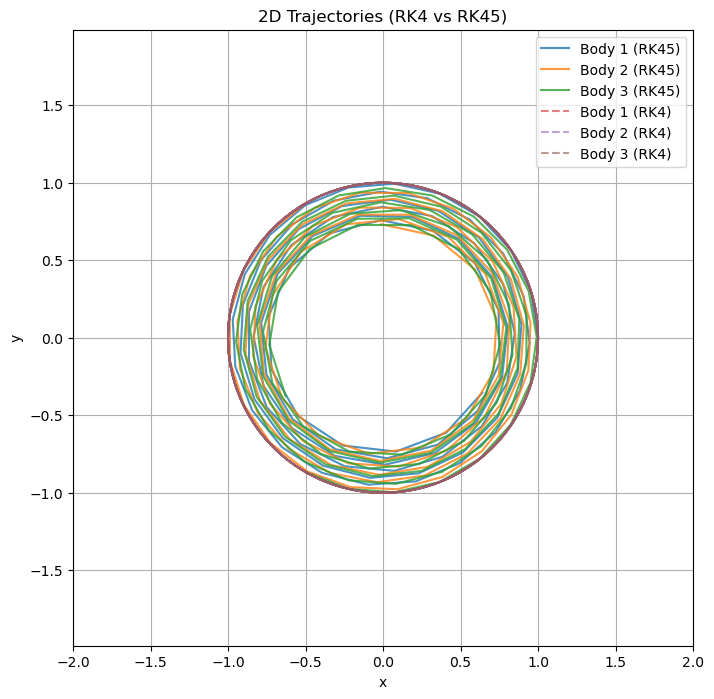

In [445]:
plt.figure(figsize=(8, 8))

# RK45 trajectories
plt.plot(p1x_rk45, p1y_rk45, label='Body 1 (RK45)', alpha=0.8)
plt.plot(p2x_rk45, p2y_rk45, label='Body 2 (RK45)', alpha=0.8)
plt.plot(p3x_rk45, p3y_rk45, label='Body 3 (RK45)', alpha=0.8)

# RK4 trajectories (dashed)
plt.plot(p1x_rk4, p1y_rk4, '--', label='Body 1 (RK4)', alpha=0.6)
plt.plot(p2x_rk4, p2y_rk4, '--', label='Body 2 (RK4)', alpha=0.6)
plt.plot(p3x_rk4, p3y_rk4, '--', label='Body 3 (RK4)', alpha=0.6)

plt.xlabel('x')
plt.ylabel('y')
plt.title('2D Trajectories (RK4 vs RK45)')
plt.legend()
plt.axis('equal')
plt.grid(True)

plt.xlim(-2, 2)
plt.ylim(-2, 2)

plt.show()


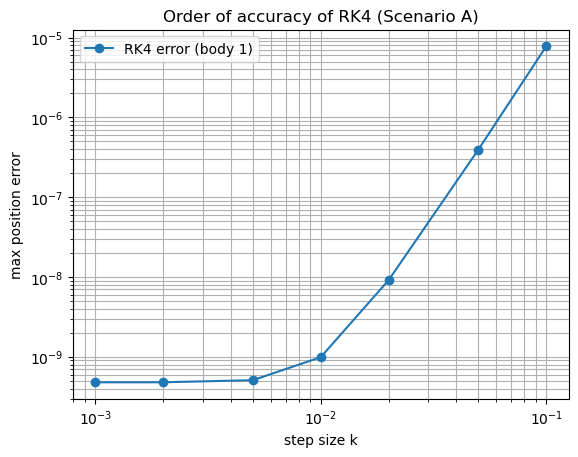

In [446]:
# Scenario A: order-of-accuracy test
t_span_A = (0.0, 10.0)        # you can adjust, but keep it moderate
masses_A = (m1A, m2A, m3A)       # equal masses from Scenario A

k_values = [0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001]

k_array, err_array = rk4_error_vs_k(init_cond_1, t_span_A, masses_A, k_values)

plt.figure()
plt.loglog(k_array, err_array, 'o-', label='RK4 error (body 1)')
plt.xlabel("step size k")
plt.ylabel("max position error")
plt.title("Order of accuracy of RK4 (Scenario A)")
plt.grid(True, which="both")
plt.legend()
plt.show()


Commento su questo plot su order of accuracy: only do the order-of-accuracy test for Scenario A, and remove the B/C copies, since convergence analysis in a chaotic scenario is less meaningful.

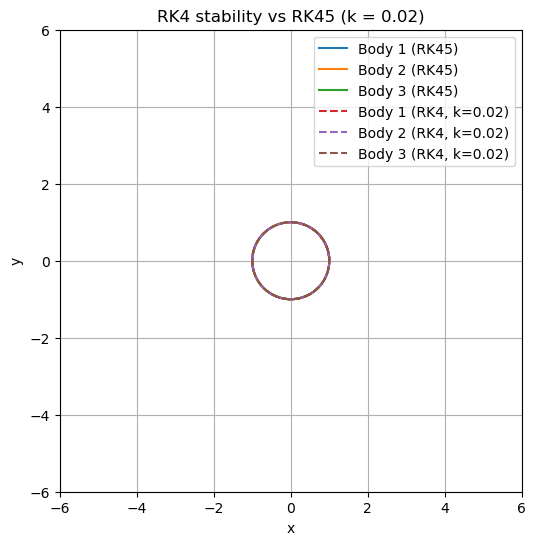

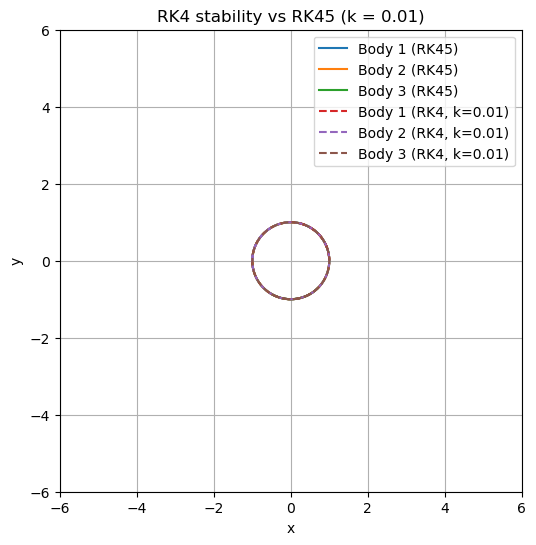

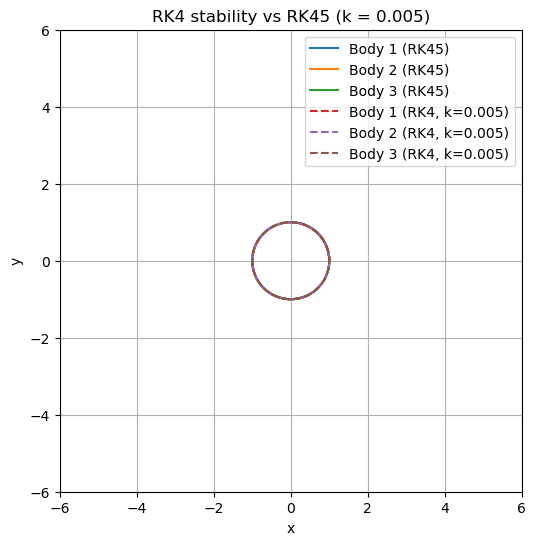

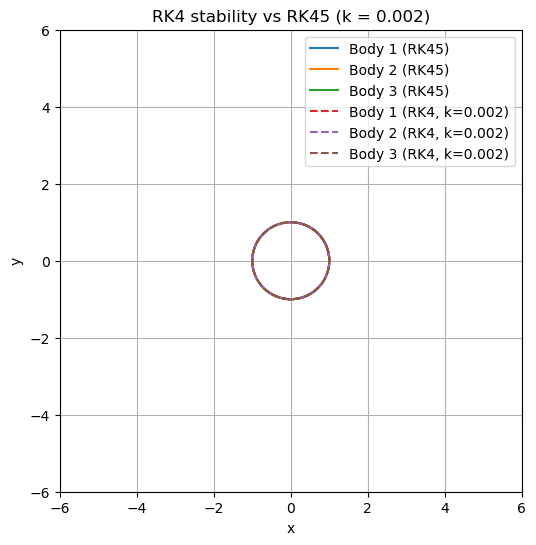

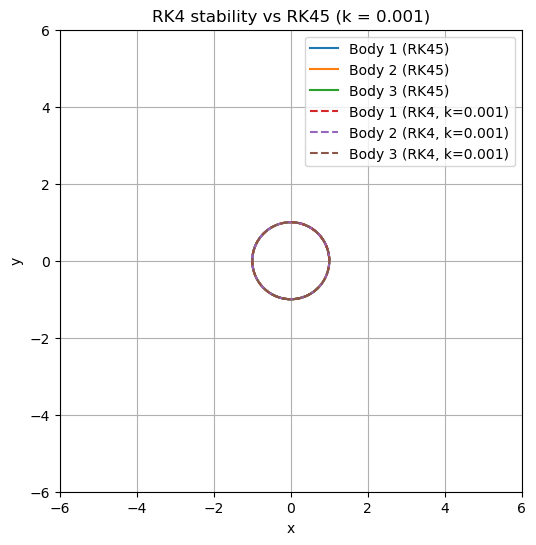

In [447]:


k_list = [0.02, 0.01, 0.005, 0.002, 0.001]

compare_rk4_stability(init_cond_1, t_span_A, masses_A, k_list)


Commento su questo plot su RK4 stability: possiamo anche non farlo per scenario A perchè sembra inutile

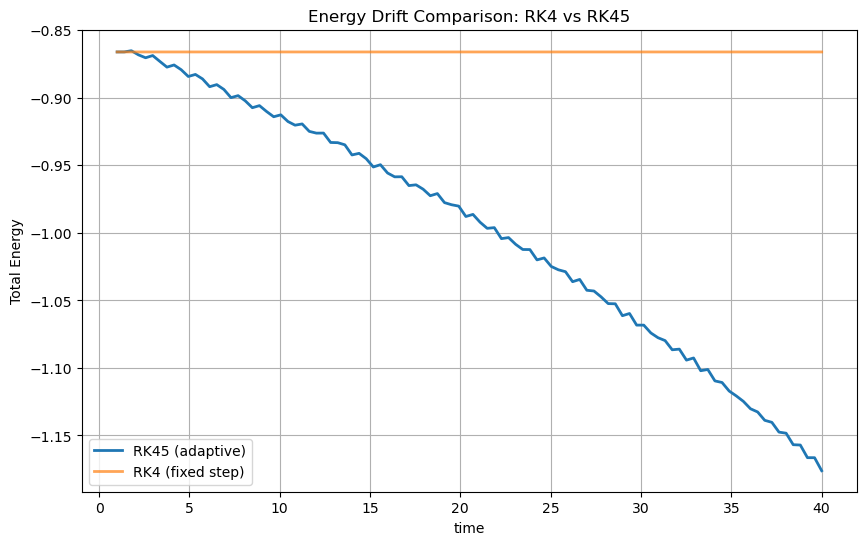

In [448]:
E_rk45 = np.array([
    total_energy(
        p1x_rk45[i], p1y_rk45[i], v1x_rk45[i], v1y_rk45[i],
        p2x_rk45[i], p2y_rk45[i], v2x_rk45[i], v2y_rk45[i],
        p3x_rk45[i], p3y_rk45[i], v3x_rk45[i], v3y_rk45[i],
        m1A, m2A, m3A
    )
    for i in range(len(t_rk45))
])

E_rk4 = np.array([
    total_energy(
        sol_rk4[i,0], sol_rk4[i,1], sol_rk4[i,6], sol_rk4[i,7],
        sol_rk4[i,2], sol_rk4[i,3], sol_rk4[i,8], sol_rk4[i,9],
        sol_rk4[i,4], sol_rk4[i,5], sol_rk4[i,10], sol_rk4[i,11],
        m1A, m2A, m3A
    )
    for i in range(len(t_rk4))
])

plt.figure(figsize=(10, 6))

plt.plot(t_rk45, E_rk45, label='RK45 (adaptive)', linewidth=2)
plt.plot(t_rk4,  E_rk4,  label='RK4 (fixed step)', linewidth=2, alpha=0.7)

plt.xlabel('time')
plt.ylabel('Total Energy')
plt.title('Energy Drift Comparison: RK4 vs RK45')
plt.legend()
plt.grid(True)
plt.show()

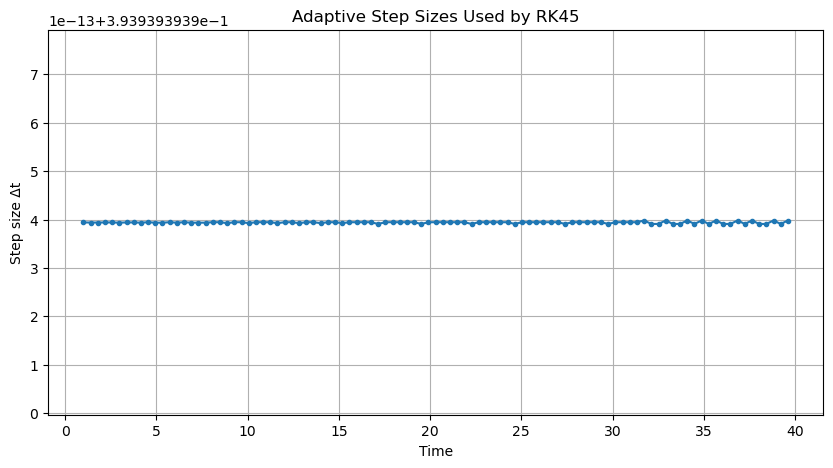

In [449]:
# Adaptive time steps of RK45
dt_rk45 = np.diff(t_rk45)

plt.figure(figsize=(10,5))
plt.plot(t_rk45[:-1], dt_rk45, marker='o', markersize=3)

plt.xlabel("Time")
plt.ylabel("Step size Δt")
plt.title("Adaptive Step Sizes Used by RK45")
plt.grid(True)
plt.show()


In [450]:
interp_rk4 = interp1d(t_rk4, sol_rk4, axis=0, fill_value="extrapolate")
sol_rk4_interp = interp_rk4(t_rk45)


In [451]:
# Positions from RK45
pos_rk45 = np.vstack([
    p1x_rk45, p1y_rk45,
    p2x_rk45, p2y_rk45,
    p3x_rk45, p3y_rk45
]).T  # shape (N, 6)

# Positions from interpolated RK4
pos_rk4i = sol_rk4_interp[:, :6]

# Euclidean position error
error = np.linalg.norm(pos_rk45 - pos_rk4i, axis=1)


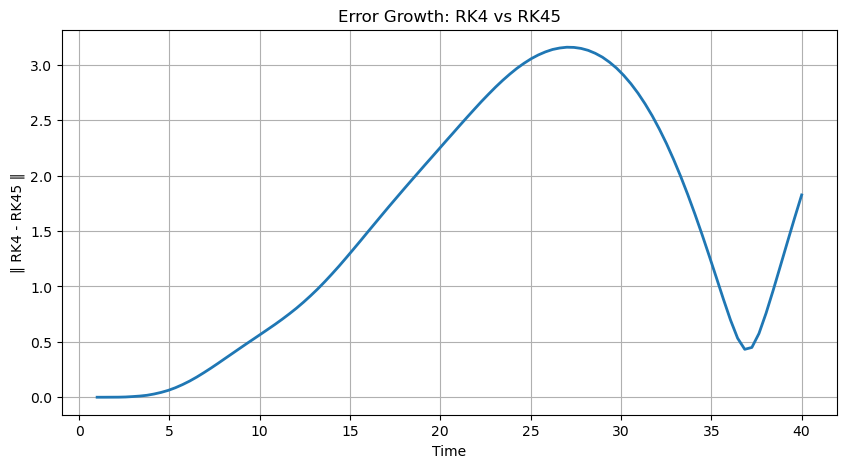

In [452]:
plt.figure(figsize=(10,5))
plt.plot(t_rk45, error, linewidth=2)

plt.xlabel("Time")
plt.ylabel("‖ RK4 - RK45 ‖")
plt.title("Error Growth: RK4 vs RK45")
plt.grid(True)
plt.show()


Now do example 2

In [453]:

time_s, time_e = 1, 40
k = 0.01
t_rk4, sol_rk4 = rk4_integrate((time_s, time_e), init_cond_2, k, m1B, m2B, m3B)

p1x_rk4 = sol_rk4[:, 0]
p1y_rk4 = sol_rk4[:, 1]

p2x_rk4 = sol_rk4[:, 2]
p2y_rk4 = sol_rk4[:, 3]

p3x_rk4 = sol_rk4[:, 4]
p3y_rk4 = sol_rk4[:, 5]

v1x_rk4 = sol_rk4[:, 6]
v1y_rk4 = sol_rk4[:, 7]

v2x_rk4 = sol_rk4[:, 8]
v2y_rk4 = sol_rk4[:, 9]

v3x_rk4 = sol_rk4[:, 10]
v3y_rk4 = sol_rk4[:, 11]

In [454]:
t_points = np.linspace(time_s, time_e, 100)


solution = solve_ivp(
    fun=system_odes, #system of ODEs 
    t_span=(time_s, time_e), #time span
    y0= init_cond_2, #set initial conditions 
    t_eval = t_points, #array of times at which to store the computed solution
    args= (m1B, m2B, m3B) #extra arguments, in our case are the masses
)

#from the solution we get the coordinates of the position
t_rk45 = solution.t

p1x_rk45 = solution.y[0]
p1y_rk45 = solution.y[1]

p2x_rk45 = solution.y[2]
p2y_rk45 = solution.y[3]

p3x_rk45 = solution.y[4]
p3y_rk45 = solution.y[5]

v1x_rk45 = solution.y[6]
v1y_rk45 = solution.y[7]

v2x_rk45 = solution.y[8]
v2y_rk45 = solution.y[9]

v3x_rk45 = solution.y[10]
v3y_rk45 = solution.y[11]



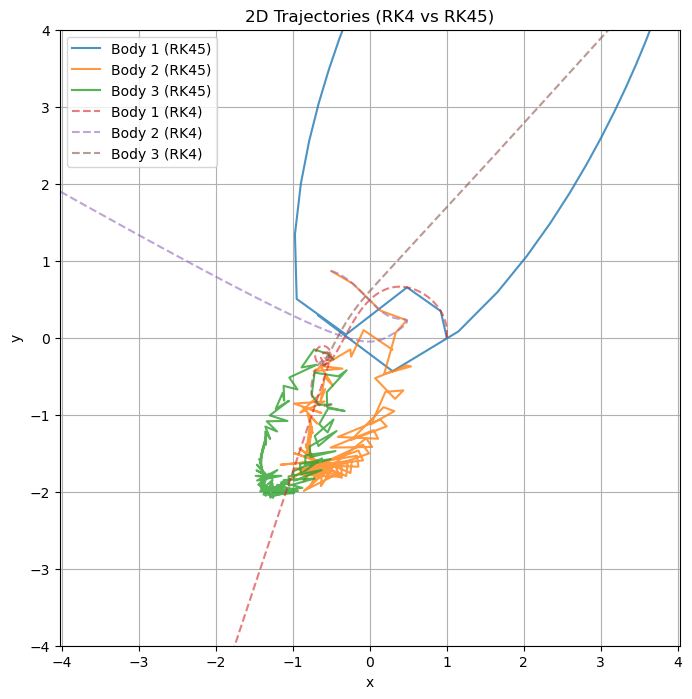

In [455]:
plt.figure(figsize=(8, 8))

# RK45 trajectories
plt.plot(p1x_rk45, p1y_rk45, label='Body 1 (RK45)', alpha=0.8)
plt.plot(p2x_rk45, p2y_rk45, label='Body 2 (RK45)', alpha=0.8)
plt.plot(p3x_rk45, p3y_rk45, label='Body 3 (RK45)', alpha=0.8)

# RK4 trajectories (dashed)
plt.plot(p1x_rk4, p1y_rk4, '--', label='Body 1 (RK4)', alpha=0.6)
plt.plot(p2x_rk4, p2y_rk4, '--', label='Body 2 (RK4)', alpha=0.6)
plt.plot(p3x_rk4, p3y_rk4, '--', label='Body 3 (RK4)', alpha=0.6)

plt.xlabel('x')
plt.ylabel('y')
plt.title('2D Trajectories (RK4 vs RK45)')
plt.legend()
plt.axis('equal')
plt.grid(True)

plt.xlim(-4,4)
plt.ylim(-4, 4)

plt.show()


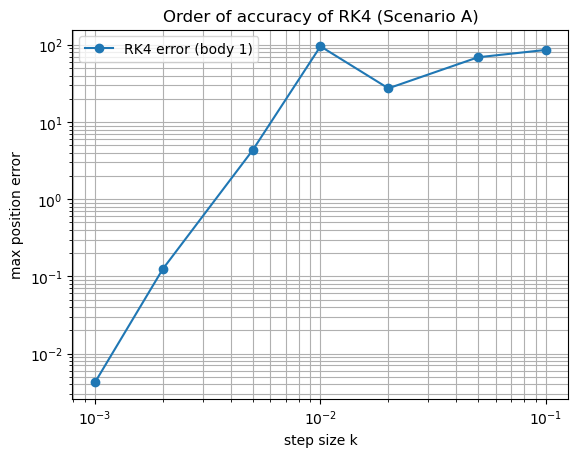

In [456]:
# Scenario B: order-of-accuracy test
t_span_B = (0.0, 10.0)        # you can adjust, but keep it moderate
masses_B = (m1B, m2B, m3B)       

k_values = [0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001]

k_array, err_array = rk4_error_vs_k(init_cond_2, t_span_B, masses_B, k_values)

plt.figure()
plt.loglog(k_array, err_array, 'o-', label='RK4 error (body 1)')
plt.xlabel("step size k")
plt.ylabel("max position error")
plt.title("Order of accuracy of RK4 (Scenario A)")
plt.grid(True, which="both")
plt.legend()
plt.show()


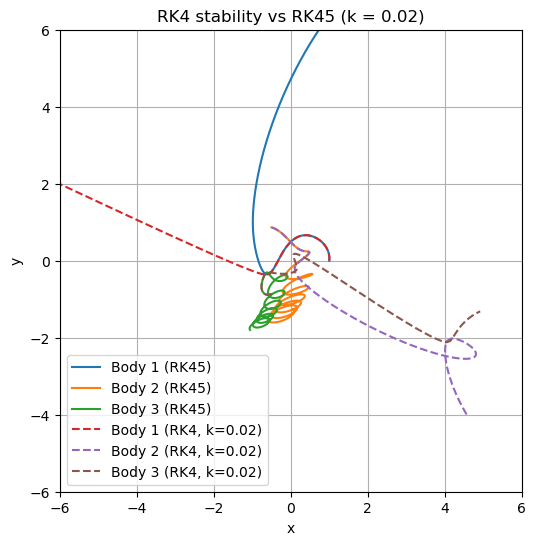

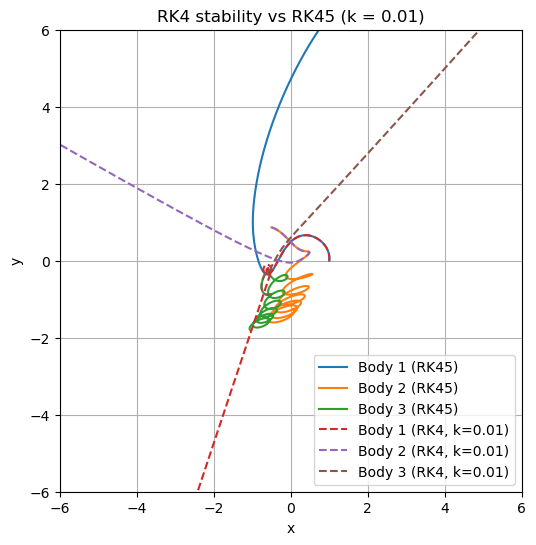

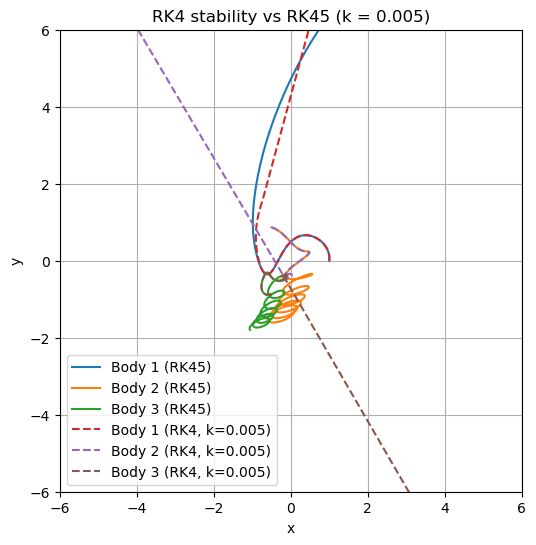

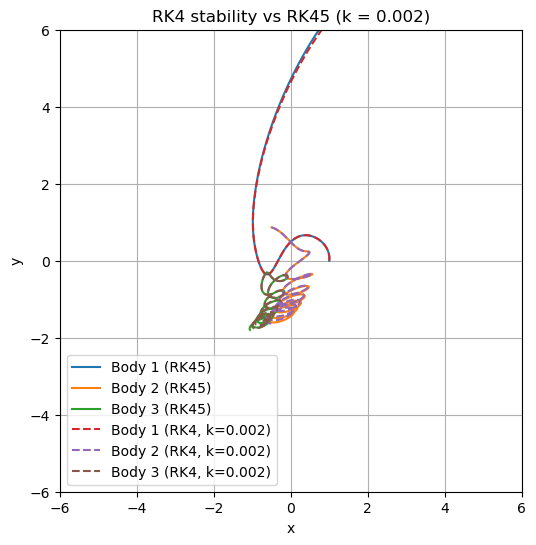

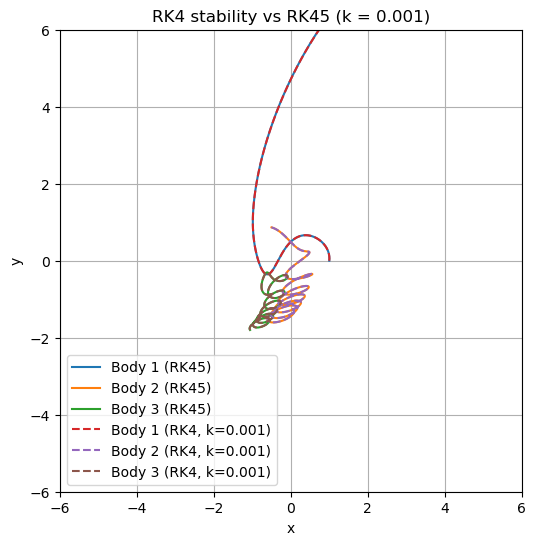

In [457]:


k_list = [0.02, 0.01, 0.005, 0.002, 0.001]

compare_rk4_stability(init_cond_2, t_span_B, masses_B, k_list)


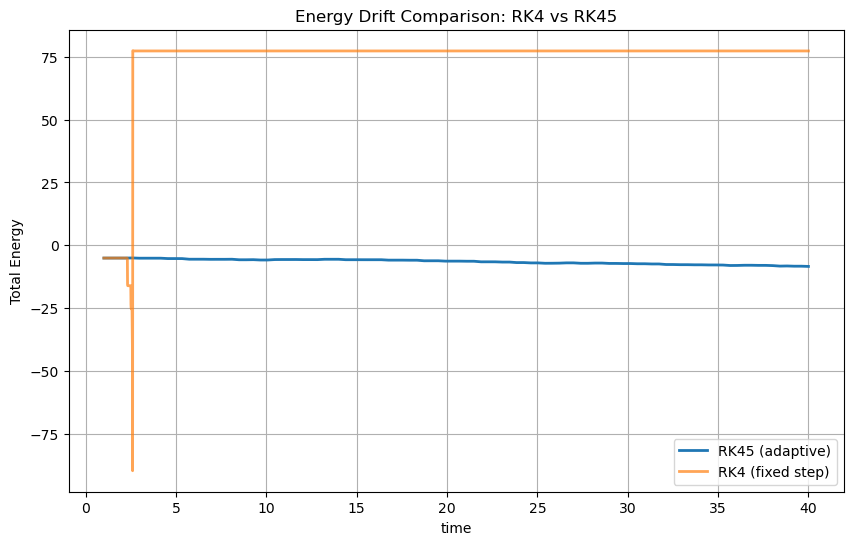

In [458]:
E_rk45 = np.array([
    total_energy(
        p1x_rk45[i], p1y_rk45[i], v1x_rk45[i], v1y_rk45[i],
        p2x_rk45[i], p2y_rk45[i], v2x_rk45[i], v2y_rk45[i],
        p3x_rk45[i], p3y_rk45[i], v3x_rk45[i], v3y_rk45[i],
        m1B, m2B, m3B
    )
    for i in range(len(t_rk45))
])

E_rk4 = np.array([
    total_energy(
        sol_rk4[i,0], sol_rk4[i,1], sol_rk4[i,6], sol_rk4[i,7],
        sol_rk4[i,2], sol_rk4[i,3], sol_rk4[i,8], sol_rk4[i,9],
        sol_rk4[i,4], sol_rk4[i,5], sol_rk4[i,10], sol_rk4[i,11],
        m1B, m2B, m3B
    )
    for i in range(len(t_rk4))
])

plt.figure(figsize=(10, 6))

plt.plot(t_rk45, E_rk45, label='RK45 (adaptive)', linewidth=2)
plt.plot(t_rk4,  E_rk4,  label='RK4 (fixed step)', linewidth=2, alpha=0.7)

plt.xlabel('time')
plt.ylabel('Total Energy')
plt.title('Energy Drift Comparison: RK4 vs RK45')
plt.legend()
plt.grid(True)
plt.show()




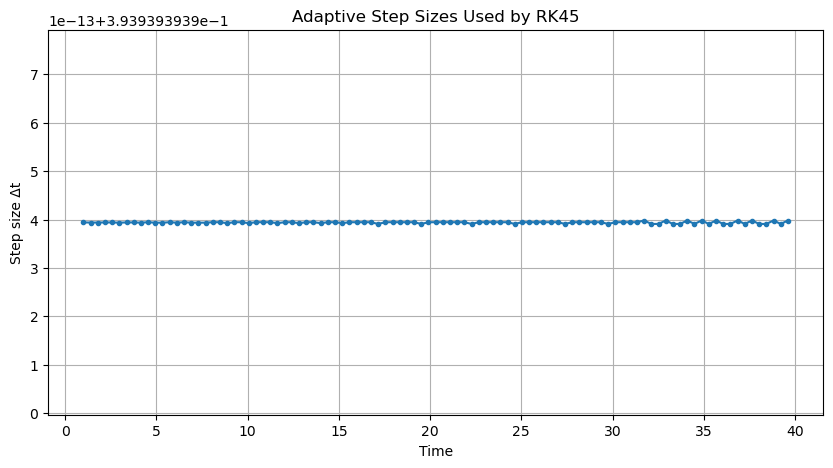

In [459]:
# Adaptive time steps of RK45
dt_rk45 = np.diff(t_rk45)

plt.figure(figsize=(10,5))
plt.plot(t_rk45[:-1], dt_rk45, marker='o', markersize=3)

plt.xlabel("Time")
plt.ylabel("Step size Δt")
plt.title("Adaptive Step Sizes Used by RK45")
plt.grid(True)
plt.show()

In [460]:
interp_rk4 = interp1d(t_rk4, sol_rk4, axis=0, fill_value="extrapolate")
sol_rk4_interp = interp_rk4(t_rk45)

In [461]:
# Positions from RK45
pos_rk45 = np.vstack([
    p1x_rk45, p1y_rk45,
    p2x_rk45, p2y_rk45,
    p3x_rk45, p3y_rk45
]).T  # shape (N, 6)

# Positions from interpolated RK4
pos_rk4i = sol_rk4_interp[:, :6]

# Euclidean position error
error = np.linalg.norm(pos_rk45 - pos_rk4i, axis=1)


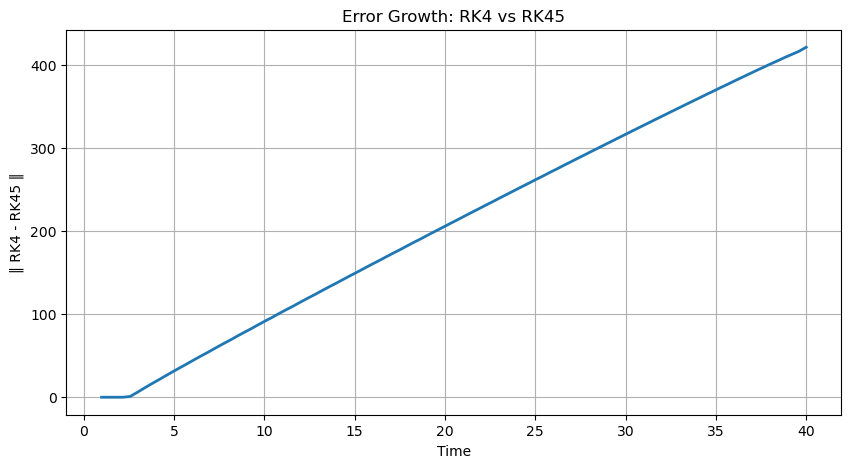

In [462]:
plt.figure(figsize=(10,5))
plt.plot(t_rk45, error, linewidth=2)

plt.xlabel("Time")
plt.ylabel("‖ RK4 - RK45 ‖")
plt.title("Error Growth: RK4 vs RK45")
plt.grid(True)
plt.show()


Finally we do it for the last example

In [463]:

time_s, time_e = 1, 20
k = 0.01
t_rk4, sol_rk4 = rk4_integrate((time_s, time_e), init_cond_3, k, m1C, m2C, m3C)

p1x_rk4 = sol_rk4[:, 0]
p1y_rk4 = sol_rk4[:, 1]

p2x_rk4 = sol_rk4[:, 2]
p2y_rk4 = sol_rk4[:, 3]

p3x_rk4 = sol_rk4[:, 4]
p3y_rk4 = sol_rk4[:, 5]

v1x_rk4 = sol_rk4[:, 6]
v1y_rk4 = sol_rk4[:, 7]

v2x_rk4 = sol_rk4[:, 8]
v2y_rk4 = sol_rk4[:, 9]

v3x_rk4 = sol_rk4[:, 10]
v3y_rk4 = sol_rk4[:, 11]

In [464]:
t_points = np.linspace(time_s, time_e, 100)


solution = solve_ivp(
    fun=system_odes, #system of ODEs 
    t_span=(time_s, time_e), #time span
    y0= init_cond_3, #set initial conditions 
    t_eval = t_points, #array of times at which to store the computed solution
    args= (m1C, m2C, m3C) #extra arguments, in our case are the masses
)

#from the solution we get the coordinates of the position
t_rk45 = solution.t

p1x_rk45 = solution.y[0]
p1y_rk45 = solution.y[1]

p2x_rk45 = solution.y[2]
p2y_rk45 = solution.y[3]

p3x_rk45 = solution.y[4]
p3y_rk45 = solution.y[5]

v1x_rk45 = solution.y[6]
v1y_rk45 = solution.y[7]

v2x_rk45 = solution.y[8]
v2y_rk45 = solution.y[9]

v3x_rk45 = solution.y[10]
v3y_rk45 = solution.y[11]



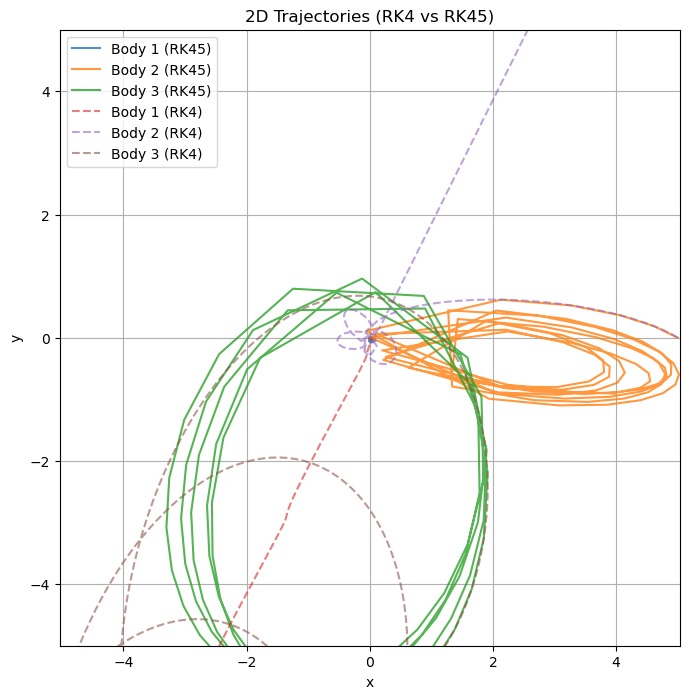

In [465]:
plt.figure(figsize=(8, 8))

# RK45 trajectories
plt.plot(p1x_rk45, p1y_rk45, label='Body 1 (RK45)', alpha=0.8)
plt.plot(p2x_rk45, p2y_rk45, label='Body 2 (RK45)', alpha=0.8)
plt.plot(p3x_rk45, p3y_rk45, label='Body 3 (RK45)', alpha=0.8)

# RK4 trajectories (dashed)
plt.plot(p1x_rk4, p1y_rk4, '--', label='Body 1 (RK4)', alpha=0.6)
plt.plot(p2x_rk4, p2y_rk4, '--', label='Body 2 (RK4)', alpha=0.6)
plt.plot(p3x_rk4, p3y_rk4, '--', label='Body 3 (RK4)', alpha=0.6)

plt.xlabel('x')
plt.ylabel('y')
plt.title('2D Trajectories (RK4 vs RK45)')
plt.legend()
plt.axis('equal')
plt.grid(True)

plt.xlim(-5, 5)
plt.ylim(-5, 5)

plt.show()


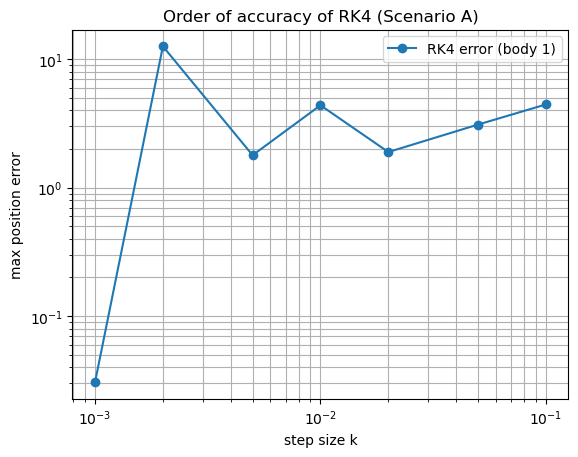

In [466]:
# Scenario C: order-of-accuracy test
t_span_C = (0.0, 10.0)        # you can adjust, but keep it moderate
masses_C = (m1C, m2C, m3C)       
k_values = [0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001]

k_array, err_array = rk4_error_vs_k(init_cond_3, t_span_C, masses_C, k_values)

plt.figure()
plt.loglog(k_array, err_array, 'o-', label='RK4 error (body 1)')
plt.xlabel("step size k")
plt.ylabel("max position error")
plt.title("Order of accuracy of RK4 (Scenario A)")
plt.grid(True, which="both")
plt.legend()
plt.show()


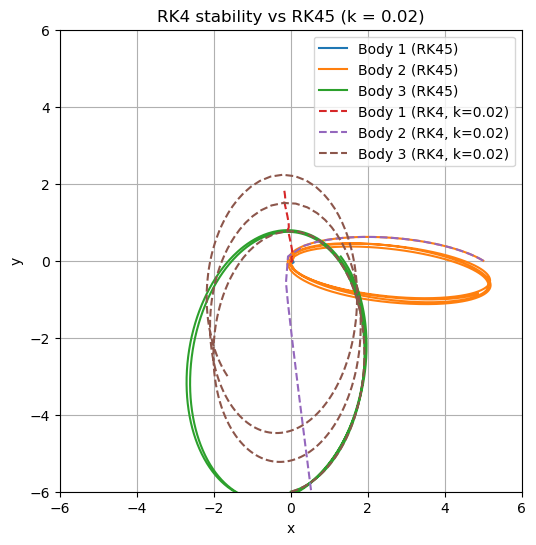

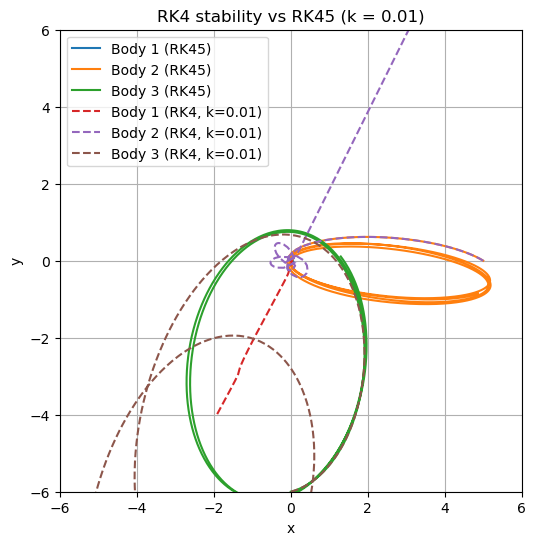

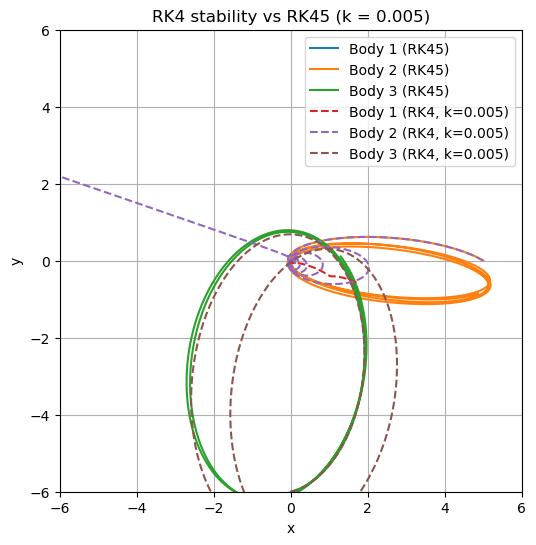

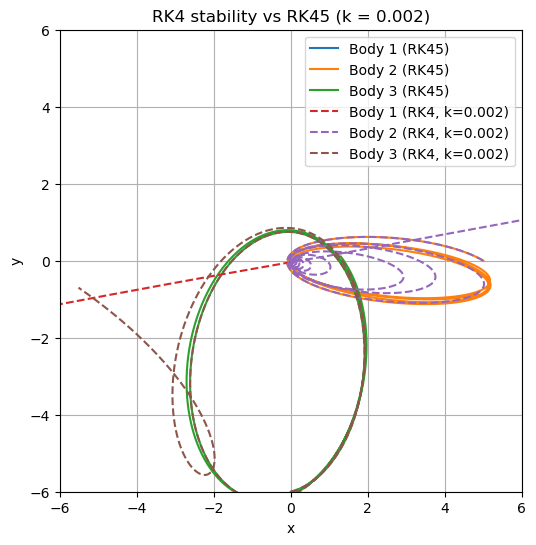

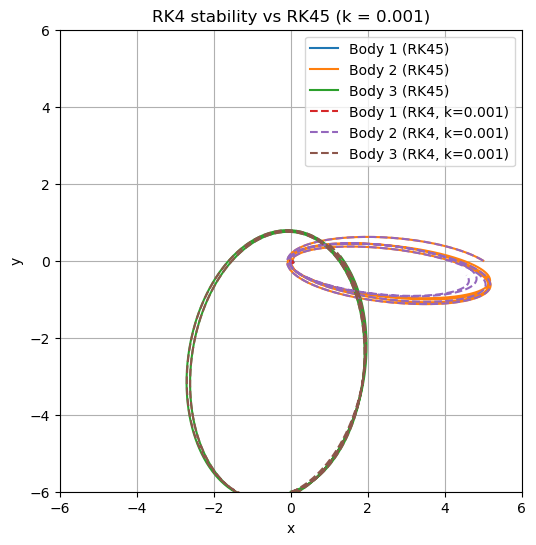

In [467]:

k_list = [0.02, 0.01, 0.005, 0.002, 0.001]

compare_rk4_stability(init_cond_3, t_span_C, masses_C, k_list)


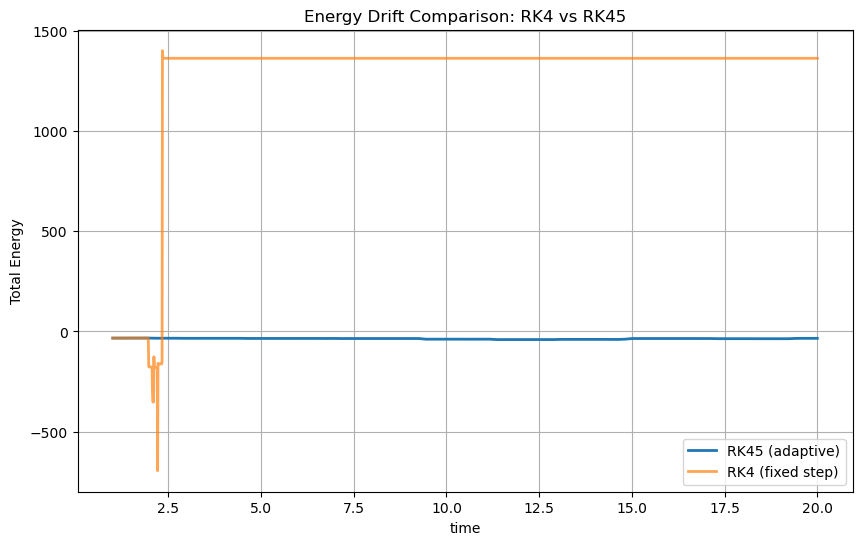

In [468]:

E_rk45 = np.array([
    total_energy(
        p1x_rk45[i], p1y_rk45[i], v1x_rk45[i], v1y_rk45[i],
        p2x_rk45[i], p2y_rk45[i], v2x_rk45[i], v2y_rk45[i],
        p3x_rk45[i], p3y_rk45[i], v3x_rk45[i], v3y_rk45[i],
        m1C, m2C, m3C
    )
    for i in range(len(t_rk45))
])

E_rk4 = np.array([
    total_energy(
        sol_rk4[i,0], sol_rk4[i,1], sol_rk4[i,6], sol_rk4[i,7],
        sol_rk4[i,2], sol_rk4[i,3], sol_rk4[i,8], sol_rk4[i,9],
        sol_rk4[i,4], sol_rk4[i,5], sol_rk4[i,10], sol_rk4[i,11],
        m1C, m2C, m3C
    )
    for i in range(len(t_rk4))
])

plt.figure(figsize=(10, 6))

plt.plot(t_rk45, E_rk45, label='RK45 (adaptive)', linewidth=2)
plt.plot(t_rk4,  E_rk4,  label='RK4 (fixed step)', linewidth=2, alpha=0.7)

plt.xlabel('time')
plt.ylabel('Total Energy')
plt.title('Energy Drift Comparison: RK4 vs RK45')
plt.legend()
plt.grid(True)
plt.show()


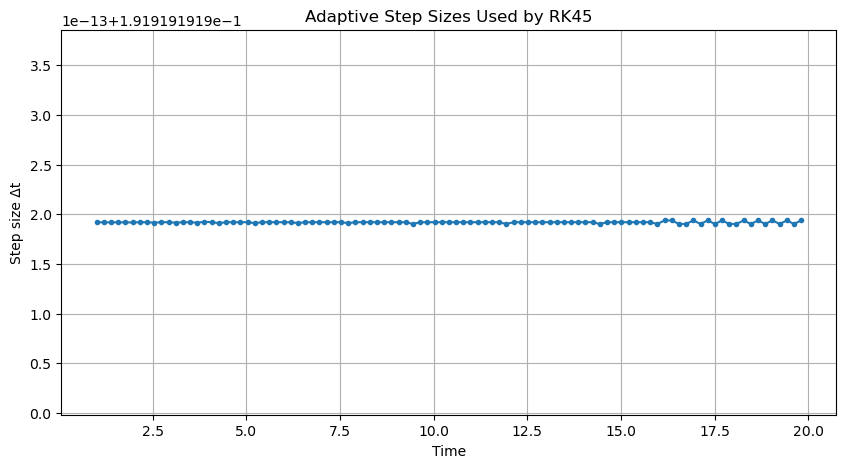

In [469]:
# Adaptive time steps of RK45
dt_rk45 = np.diff(t_rk45)

plt.figure(figsize=(10,5))
plt.plot(t_rk45[:-1], dt_rk45, marker='o', markersize=3)

plt.xlabel("Time")
plt.ylabel("Step size Δt")
plt.title("Adaptive Step Sizes Used by RK45")
plt.grid(True)
plt.show()


In [470]:
interp_rk4 = interp1d(t_rk4, sol_rk4, axis=0, fill_value="extrapolate")
sol_rk4_interp = interp_rk4(t_rk45)

In [471]:
# Positions from RK45
pos_rk45 = np.vstack([
    p1x_rk45, p1y_rk45,
    p2x_rk45, p2y_rk45,
    p3x_rk45, p3y_rk45
]).T  # shape (N, 6)

# Positions from interpolated RK4
pos_rk4i = sol_rk4_interp[:, :6]

# Euclidean position error
error = np.linalg.norm(pos_rk45 - pos_rk4i, axis=1)


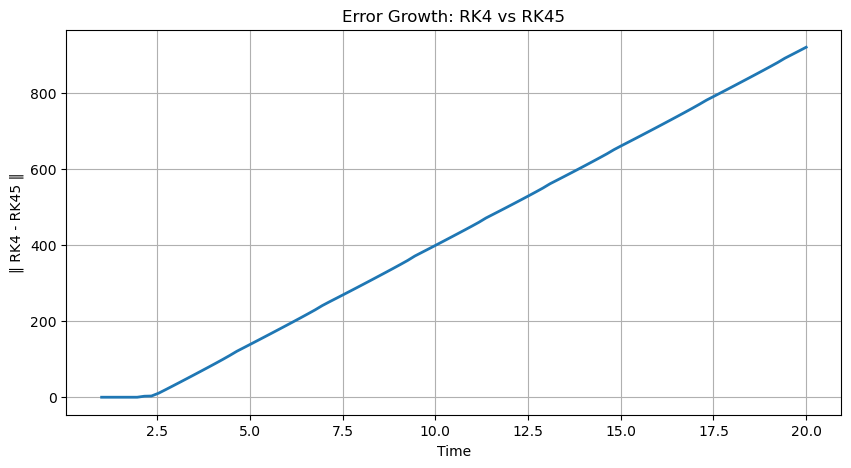

In [472]:
plt.figure(figsize=(10,5))
plt.plot(t_rk45, error, linewidth=2)

plt.xlabel("Time")
plt.ylabel("‖ RK4 - RK45 ‖")
plt.title("Error Growth: RK4 vs RK45")
plt.grid(True)
plt.show()
